# Car Price Prediction::

Download dataset from this link:

https://www.kaggle.com/hellbuoy/car-price-prediction

# Problem Statement::

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

Which variables are significant in predicting the price of a car
How well those variables describe the price of a car
Based on various market surveys, the consulting firm has gathered a large data set of different types of cars across the America market.

# task::
We are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

# WORKFLOW ::

1.Load Data

2.Check Missing Values ( If Exist ; Fill each record with mean of its feature )

3.Split into 50% Training(Samples,Labels) , 30% Test(Samples,Labels) and 20% Validation Data(Samples,Labels).

4.Model : input Layer (No. of features ), 3 hidden layers including 10,8,6 unit & Output Layer with activation function relu/tanh (check by experiment).

5.Compilation Step (Note : Its a Regression problem , select loss , metrics according to it)
6.Train the Model with Epochs (100) and validate it

7.If the model gets overfit tune your model by changing the units , No. of layers , activation function , epochs , add dropout layer or add Regularizer according to the need .

8.Evaluation Step

9.Prediction

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d hellbuoy/car-price-prediction

  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 29.8MB/s]


In [7]:
!mkdir car-price-prediction

In [8]:
! unzip car-price-prediction.zip -d car-price-prediction

Archive:  car-price-prediction.zip
  inflating: car-price-prediction/CarPrice_Assignment.csv  
  inflating: car-price-prediction/Data Dictionary - carprices.xlsx  


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor

In [10]:
data = pd.read_csv("/content/car-price-prediction/CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [11]:
data.shape

(205, 26)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [13]:
data.drop(["car_ID"], axis="columns", inplace=True)

In [14]:
lb_make = LabelEncoder()

In [15]:
cate_df_object = data.select_dtypes(include=['object']).copy()
for i in cate_df_object:
  cate_df_object[i] = lb_make.fit_transform(cate_df_object[i])
cate_df_object.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,2,1,0,1,0,2,0,0,2,5
1,3,1,0,1,0,2,0,0,2,5
2,1,1,0,1,2,2,0,5,3,5
3,4,1,0,0,3,1,0,3,2,5
4,5,1,0,0,3,0,0,3,1,5


In [16]:
cate_df_int = data.select_dtypes(include=['int64']).copy()
for i in cate_df_int:
  cate_df_int[i]=(cate_df_int[i]-cate_df_int[i].min())/(cate_df_int[i].max()-cate_df_int[i].min())
cate_df_int.head()

,symboling,curbweight,enginesize,horsepower,peakrpm,citympg,highwaympg
0,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474
1,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474
2,0.6,0.517843,0.343396,0.441667,0.346939,0.166667,0.263158
3,0.8,0.329325,0.181132,0.225000,0.551020,0.305556,0.368421
4,0.8,0.518231,0.283019,0.279167,0.551020,0.138889,0.157895


In [17]:
cate_df_float = data.select_dtypes(include=['float64']).copy()
for i in cate_df_float:
  cate_df_float[i]=(cate_df_float[i]-cate_df_float[i].min())/(cate_df_float[i].max()-cate_df_float[i].min())
cate_df_float.head()

,wheelbase,carlength,carwidth,carheight,boreratio,stroke,compressionratio,price
0,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.1250,0.207959
1,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.1250,0.282558
2,0.230321,0.449254,0.433333,0.383333,0.100000,0.666667,0.1250,0.282558
3,0.384840,0.529851,0.491667,0.541667,0.464286,0.633333,0.1875,0.219254
4,0.373178,0.529851,0.508333,0.541667,0.464286,0.633333,0.0625,0.306142


In [18]:
data = cate_df_object.join(cate_df_int)
data = data.join(cate_df_float)
data.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,symboling,curbweight,enginesize,horsepower,peakrpm,citympg,highwaympg,wheelbase,carlength,carwidth,carheight,boreratio,stroke,compressionratio,price
0,2,1,0,1,0,2,0,0,2,5,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.1250,0.207959
1,3,1,0,1,0,2,0,0,2,5,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.1250,0.282558
2,1,1,0,1,2,2,0,5,3,5,0.6,0.517843,0.343396,0.441667,0.346939,0.166667,0.263158,0.230321,0.449254,0.433333,0.383333,0.100000,0.666667,0.1250,0.282558
3,4,1,0,0,3,1,0,3,2,5,0.8,0.329325,0.181132,0.225000,0.551020,0.305556,0.368421,0.384840,0.529851,0.491667,0.541667,0.464286,0.633333,0.1875,0.219254
4,5,1,0,0,3,0,0,3,1,5,0.8,0.518231,0.283019,0.279167,0.551020,0.138889,0.157895,0.373178,0.529851,0.508333,0.541667,0.464286,0.633333,0.0625,0.306142


In [19]:
dependent_vars = data["price"]

In [20]:
dependent_vars

0      0.207959
1      0.282558
2      0.282558
3      0.219254
4      0.306142
         ...   
200    0.291123
201    0.345738
202    0.406311
203    0.430763
204    0.434611
Name: price, Length: 205, dtype: float64

In [21]:
independent_vars = data.drop("price",axis=1)

In [22]:
independent_vars

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,symboling,curbweight,enginesize,horsepower,peakrpm,citympg,highwaympg,wheelbase,carlength,carwidth,carheight,boreratio,stroke,compressionratio
0,2,1,0,1,0,2,0,0,2,5,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.12500
1,3,1,0,1,0,2,0,0,2,5,1.0,0.411171,0.260377,0.262500,0.346939,0.222222,0.289474,0.058309,0.413433,0.316667,0.083333,0.664286,0.290476,0.12500
2,1,1,0,1,2,2,0,5,3,5,0.6,0.517843,0.343396,0.441667,0.346939,0.166667,0.263158,0.230321,0.449254,0.433333,0.383333,0.100000,0.666667,0.12500
3,4,1,0,0,3,1,0,3,2,5,0.8,0.329325,0.181132,0.225000,0.551020,0.305556,0.368421,0.384840,0.529851,0.491667,0.541667,0.464286,0.633333,0.18750
4,5,1,0,0,3,0,0,3,1,5,0.8,0.518231,0.283019,0.279167,0.551020,0.138889,0.157895,0.373178,0.529851,0.508333,0.541667,0.464286,0.633333,0.06250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,139,1,0,0,3,2,0,3,2,5,0.2,0.567882,0.301887,0.275000,0.510204,0.277778,0.315789,0.655977,0.711940,0.716667,0.641667,0.885714,0.514286,0.15625
201,138,1,1,0,3,2,0,3,2,5,0.2,0.605508,0.301887,0.466667,0.469388,0.166667,0.236842,0.655977,0.711940,0.708333,0.641667,0.885714,0.514286,0.10625
202,140,1,0,0,3,2,0,5,3,5,0.2,0.591156,0.422642,0.358333,0.551020,0.138889,0.184211,0.655977,0.711940,0.716667,0.641667,0.742857,0.380952,0.11250
203,142,0,1,0,3,2,0,3,3,3,0.2,0.670675,0.316981,0.241667,0.265306,0.361111,0.289474,0.655977,0.711940,0.716667,0.641667,0.335714,0.633333,1.00000


In [23]:
X_train, X_test, y_train, y_test = train_test_split(independent_vars, dependent_vars, test_size=0.50)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.40)

In [175]:
# def baseline_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(13, input_dim=independent_vars.shape[1], kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

In [177]:
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, verbose=1)
# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator, independent_vars, dependent_vars, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1034
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 11/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 13/100
6/6 [==============================] - 0s 2ms/st

In [24]:
model = Sequential()
model.add(Dense(20, input_dim=independent_vars.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1,))
model.compile(loss='mse', optimizer='adam', metrics=["mae"])

In [27]:
history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_validation, y_validation))

Epoch 1/40
4/4 [==============================] - 0s 47ms/step - loss: 0.3165 - mae: 0.4692 - val_loss: 0.4323 - val_mae: 0.5864
Epoch 2/40
4/4 [==============================] - 0s 17ms/step - loss: 0.3126 - mae: 0.4658 - val_loss: 0.4293 - val_mae: 0.5845
Epoch 3/40
4/4 [==============================] - 0s 19ms/step - loss: 0.3090 - mae: 0.4625 - val_loss: 0.4259 - val_mae: 0.5823
Epoch 4/40
4/4 [==============================] - 0s 16ms/step - loss: 0.3053 - mae: 0.4593 - val_loss: 0.4199 - val_mae: 0.5780
Epoch 5/40
4/4 [==============================] - 0s 16ms/step - loss: 0.3011 - mae: 0.4556 - val_loss: 0.4102 - val_mae: 0.5706
Epoch 6/40
4/4 [==============================] - 0s 17ms/step - loss: 0.2967 - mae: 0.4522 - val_loss: 0.3999 - val_mae: 0.5627
Epoch 7/40
4/4 [==============================] - 0s 17ms/step - loss: 0.2916 - mae: 0.4481 - val_loss: 0.3924 - val_mae: 0.5572
Epoch 8/40
4/4 [==============================] - 0s 15ms/step - loss: 0.2865 - mae: 0.4434 - val

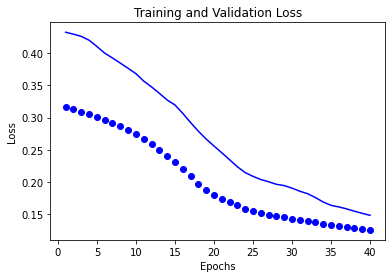

In [28]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Trainig Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

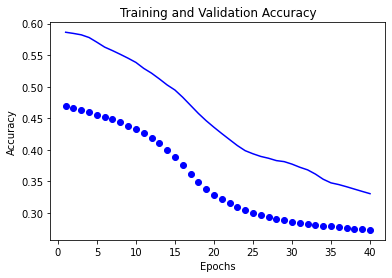

In [29]:
accuracy = history.history["mae"]
val_accuracy = history.history["val_mae"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Trainig Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [30]:
y_pred = model.predict(X_test)

In [34]:
score = mean_squared_error(y_test, y_pred)
score

0.07888000425453287

In [33]:
np.sqrt(score)

0.28085584247890033